# TODO:
 1. Create (small) Dataset for comparison of different data imputation techniques
 2. Run several imputation methods
 3. Compare them in time and accuracy
 4. Write first chapter of thesis!

Imputation techniques:
* mean / median
* k-NN
* MICE
* Maybe some additional methods at a later point


In [2]:
import time

import numpy as np
import pandas as pd
import missingno as msno
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt

from NDBC_Buoy_Data import myLibrary as mL
from IPython.core.display_functions import display

----

# Build Dataset

Find station and year with lowest num of NaN values!

In [11]:
stations = mL.stations_GOM
years = ["2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020" "2021", "2022"]

NaN_statistic = pd.DataFrame()
for year in years:
    for stationID in mL.cleaned_stations_GOM:
        data = mL.get_data_file(stationID, year)
        if data is not None:
            data = mL.df_modification(data)[1]
            data = mL.replace_with_NaN(data)
            num_values, num_NaN_percentage, NaN_by_feature = mL.print_NaN_statistic(data, "", silent=True)

            new_row = pd.DataFrame({
                    "StationID": [stationID],
                    "Year": [year],
                    "#NaN in %": [num_NaN_percentage]
                })
            NaN_statistic = pd.concat([NaN_statistic, new_row])

Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404

In [12]:
NaN_statistic

,StationID,Year,#NaN in %
0,41112,2010,61.86
0,42001,2010,54.82
0,42002,2010,39.09
0,42012,2010,17.21
0,42013,2010,81.65
...,...,...,...
0,vcat2,2019,56.10
0,venf1,2019,46.48
0,wiwf1,2019,91.53
0,wplf1,2019,91.53


As we can see, the dataset of station 42001 of the year 2016 includes the lowest amount of NaN values, so lets continue with that file.

In [13]:
test_data = mL.get_data_file("42001", "2016")
test_data = mL.df_modification(test_data)[1]
test_data = mL.replace_with_NaN(test_data)
test_data

,WDIR_42001,WSPD_42001,GST_42001,WVHT_42001,DPD_42001,APD_42001,MWD_42001,PRES_42001,ATMP_42001,WTMP_42001,DEWP_42001,VIS_42001,TIDE_42001
timestamp,,,,,,,,,,,,,
2016-03-30 09:50:00,115,9.2,10.8,1.19,5.00,3.98,93,1013.2,24.3,23.9,23.2,NaN,NaN
2016-03-30 10:50:00,114,7.1,8.5,1.17,5.56,4.47,95,1013.5,24.4,23.9,23.2,NaN,NaN
2016-03-30 11:50:00,116,7.8,9.0,1.20,5.56,4.48,102,1013.7,24.4,23.9,23.0,NaN,NaN
2016-03-30 12:50:00,116,7.4,8.5,1.24,6.25,4.56,94,1014.4,24.5,23.9,23.1,NaN,NaN
2016-03-30 13:50:00,118,7.7,9.0,1.28,5.88,4.73,95,1014.9,24.7,23.9,23.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 18:50:00,166,9.2,11.3,1.52,6.67,4.81,76,1016.2,24.2,24.7,18.9,NaN,NaN
2016-12-31 19:50:00,155,9.3,11.1,1.68,5.56,4.93,138,1014.9,24.3,24.7,19.0,NaN,NaN
2016-12-31 20:50:00,161,9.2,10.5,1.58,6.25,4.90,100,1014.4,24.5,24.8,19.5,NaN,NaN


<AxesSubplot: >

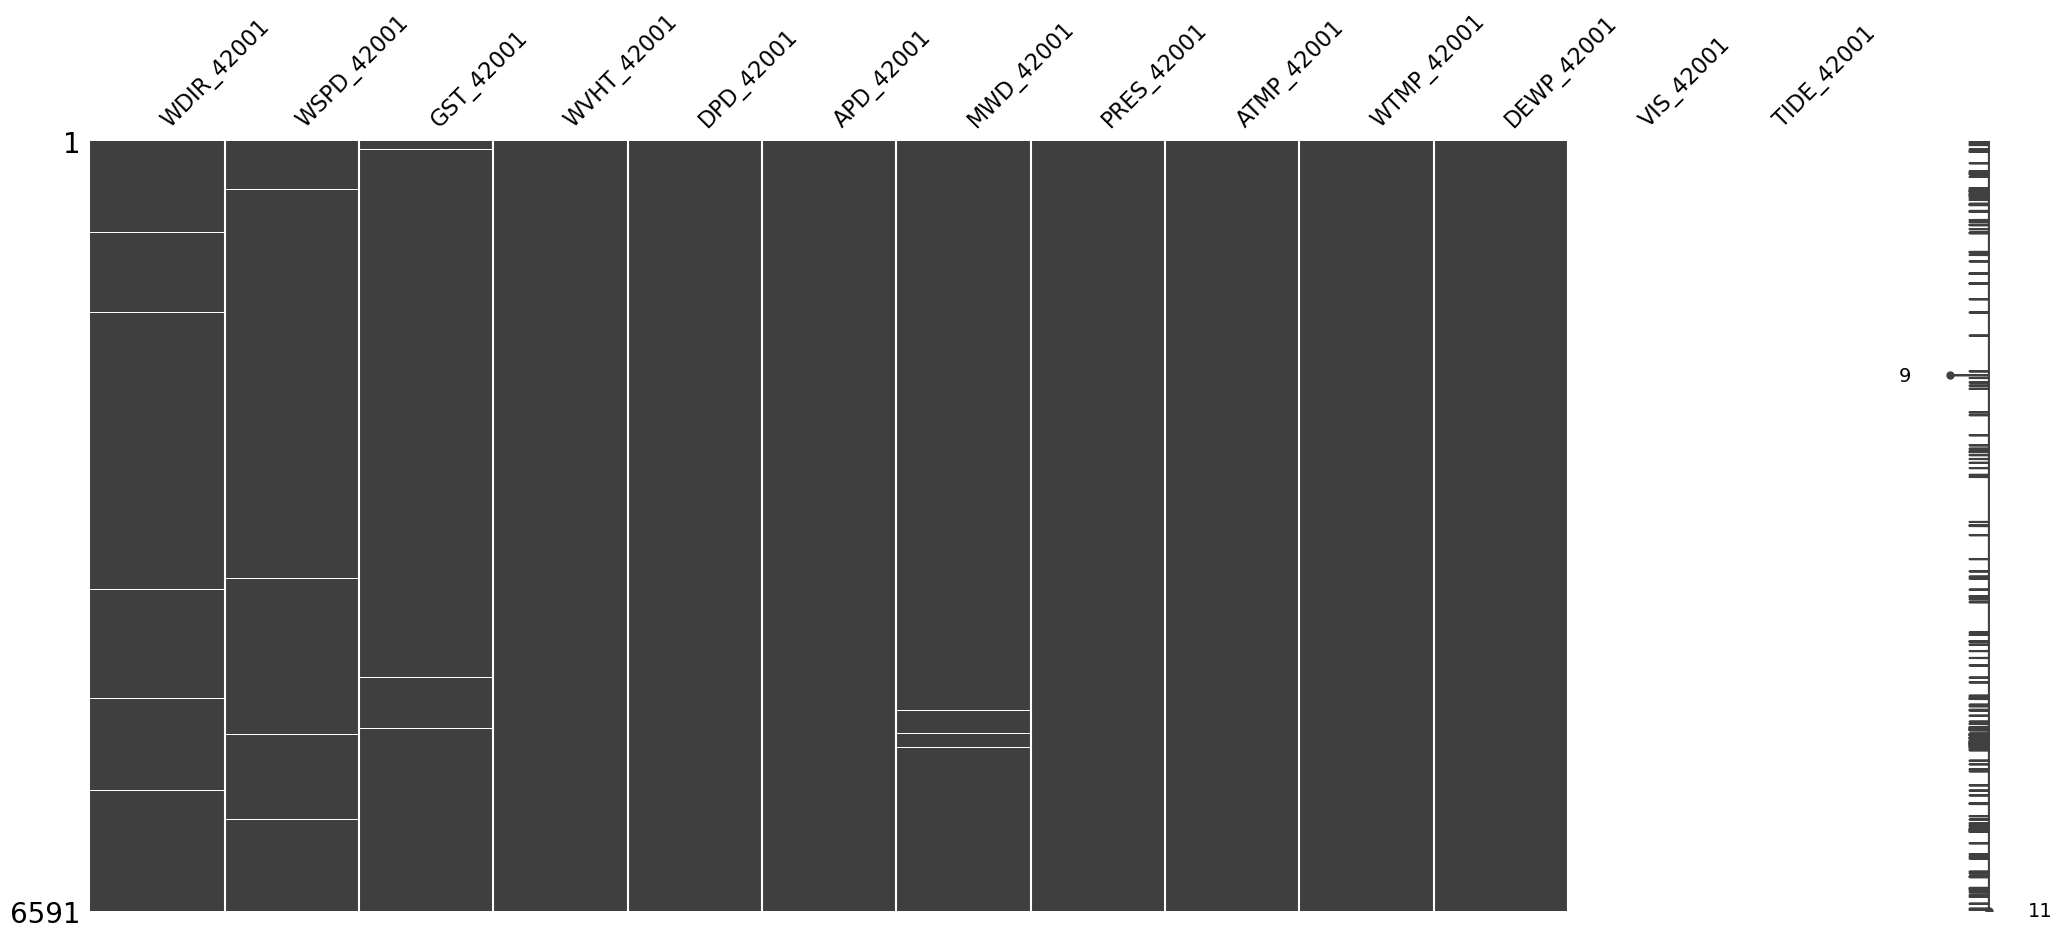

In [15]:
msno.matrix(test_data)

The graph shows that the features VIS and TIDE do not provide any values, so lets those colums without any values!

In [16]:
#test_data = mL.drop_NaN_rows_and_cols(test_data) #ORIGINAL!
test_data = test_data.dropna(axis=1, how='all')  # drop cols if all values are NaN  #ATTENTION: CODE CHANGED WITHOUT EXECUTION!!!!
test_data.head()

,WDIR_42001,WSPD_42001,GST_42001,WVHT_42001,DPD_42001,APD_42001,MWD_42001,PRES_42001,ATMP_42001,WTMP_42001,DEWP_42001
timestamp,,,,,,,,,,,
2016-03-30 09:50:00,115,9.2,10.8,1.19,5.00,3.98,93,1013.2,24.3,23.9,23.2
2016-03-30 10:50:00,114,7.1,8.5,1.17,5.56,4.47,95,1013.5,24.4,23.9,23.2
2016-03-30 11:50:00,116,7.8,9.0,1.20,5.56,4.48,102,1013.7,24.4,23.9,23.0
2016-03-30 12:50:00,116,7.4,8.5,1.24,6.25,4.56,94,1014.4,24.5,23.9,23.1
2016-03-30 13:50:00,118,7.7,9.0,1.28,5.88,4.73,95,1014.9,24.7,23.9,23.0


In [17]:
num_values, num_NaN_percentage, NaN_by_feature = mL.print_NaN_statistic(test_data, "") #unneeded


 
number of values:  72501
number of NaN values:  175 ( 0.24 %)



In [18]:
NaN_by_feature

,Feature,#NaN,%NaN
0,WDIR_42001,49,0.74
1,WSPD_42001,22,0.33
2,GST_42001,38,0.58
3,WVHT_42001,0,0.00
4,DPD_42001,0,0.00
5,APD_42001,0,0.00
6,MWD_42001,66,1.00
7,PRES_42001,0,0.00
8,ATMP_42001,0,0.00
9,WTMP_42001,0,0.00


We do still have some NaN values ... now we delete those rows!

In [19]:
test_data = test_data.dropna(axis=0, how="any")  # drop rows if all values are NaN
test_data

,WDIR_42001,WSPD_42001,GST_42001,WVHT_42001,DPD_42001,APD_42001,MWD_42001,PRES_42001,ATMP_42001,WTMP_42001,DEWP_42001
timestamp,,,,,,,,,,,
2016-03-30 09:50:00,115,9.2,10.8,1.19,5.00,3.98,93,1013.2,24.3,23.9,23.2
2016-03-30 10:50:00,114,7.1,8.5,1.17,5.56,4.47,95,1013.5,24.4,23.9,23.2
2016-03-30 11:50:00,116,7.8,9.0,1.20,5.56,4.48,102,1013.7,24.4,23.9,23.0
2016-03-30 12:50:00,116,7.4,8.5,1.24,6.25,4.56,94,1014.4,24.5,23.9,23.1
2016-03-30 13:50:00,118,7.7,9.0,1.28,5.88,4.73,95,1014.9,24.7,23.9,23.0
...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 18:50:00,166,9.2,11.3,1.52,6.67,4.81,76,1016.2,24.2,24.7,18.9
2016-12-31 19:50:00,155,9.3,11.1,1.68,5.56,4.93,138,1014.9,24.3,24.7,19.0
2016-12-31 20:50:00,161,9.2,10.5,1.58,6.25,4.90,100,1014.4,24.5,24.8,19.5


In [21]:
mL.print_NaN_statistic(test_data, "Are all NaN values removed?")


 Are all NaN values removed?
number of values:  70587
number of NaN values:  0 ( 0.0 %)



(70587,
 0.0,
        Feature  #NaN  %NaN
 0   WDIR_42001     0   0.0
 1   WSPD_42001     0   0.0
 2    GST_42001     0   0.0
 3   WVHT_42001     0   0.0
 4    DPD_42001     0   0.0
 5    APD_42001     0   0.0
 6    MWD_42001     0   0.0
 7   PRES_42001     0   0.0
 8   ATMP_42001     0   0.0
 9   WTMP_42001     0   0.0
 10  DEWP_42001     0   0.0)

--> All NaN values have successfully been removed. That means a "ground truth" dataset has successfully been created!

In [23]:
test_data.to_pickle("../data/NaN_ground_truth")

---

# Prepare evaluation
- exchange x% of the values at a random positon with NaN

In [4]:
test_data = pd.read_pickle("../../data/NaN_ground_truth").astype(float)

In [5]:
test_data

,WDIR_42001,WSPD_42001,GST_42001,WVHT_42001,DPD_42001,APD_42001,MWD_42001,PRES_42001,ATMP_42001,WTMP_42001,DEWP_42001
timestamp,,,,,,,,,,,
2016-03-30 09:50:00,115.0,9.2,10.8,1.19,5.00,3.98,93.0,1013.2,24.3,23.9,23.2
2016-03-30 10:50:00,114.0,7.1,8.5,1.17,5.56,4.47,95.0,1013.5,24.4,23.9,23.2
2016-03-30 11:50:00,116.0,7.8,9.0,1.20,5.56,4.48,102.0,1013.7,24.4,23.9,23.0
2016-03-30 12:50:00,116.0,7.4,8.5,1.24,6.25,4.56,94.0,1014.4,24.5,23.9,23.1
2016-03-30 13:50:00,118.0,7.7,9.0,1.28,5.88,4.73,95.0,1014.9,24.7,23.9,23.0
...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 18:50:00,166.0,9.2,11.3,1.52,6.67,4.81,76.0,1016.2,24.2,24.7,18.9
2016-12-31 19:50:00,155.0,9.3,11.1,1.68,5.56,4.93,138.0,1014.9,24.3,24.7,19.0
2016-12-31 20:50:00,161.0,9.2,10.5,1.58,6.25,4.90,100.0,1014.4,24.5,24.8,19.5


In [6]:
mL.print_NaN_statistic(test_data, "Are all NaN values removed?")


 Are all NaN values removed?
number of values:  70587
number of NaN values:  0 ( 0.0 %)



(70587,
 0.0,
        Feature  #NaN  %NaN
 0   WDIR_42001     0   0.0
 1   WSPD_42001     0   0.0
 2    GST_42001     0   0.0
 3   WVHT_42001     0   0.0
 4    DPD_42001     0   0.0
 5    APD_42001     0   0.0
 6    MWD_42001     0   0.0
 7   PRES_42001     0   0.0
 8   ATMP_42001     0   0.0
 9   WTMP_42001     0   0.0
 10  DEWP_42001     0   0.0)

# Data normalization

In [7]:
scaler = MinMaxScaler()
test_data = pd.DataFrame(scaler.fit_transform(test_data), columns = test_data.columns)
test_data.head()

,WDIR_42001,WSPD_42001,GST_42001,WVHT_42001,DPD_42001,APD_42001,MWD_42001,PRES_42001,ATMP_42001,WTMP_42001,DEWP_42001
0,0.317549,0.621622,0.563158,0.268571,0.146277,0.192771,0.256267,0.376068,0.386555,0.055556,0.73125
1,0.314763,0.479730,0.442105,0.262857,0.176064,0.291165,0.261838,0.388889,0.394958,0.055556,0.73125
2,0.320334,0.527027,0.468421,0.271429,0.176064,0.293173,0.281337,0.397436,0.394958,0.055556,0.71875
3,0.320334,0.500000,0.442105,0.282857,0.212766,0.309237,0.259053,0.427350,0.403361,0.055556,0.72500
4,0.325905,0.520270,0.468421,0.294286,0.193085,0.343373,0.261838,0.448718,0.420168,0.055556,0.71875


## TODO:

- Evaluate data imputation techniques depending on % of NaN values in the perspective of execution time (clock time or CPU time?) and accuracy
- Also consider executing it on Google Colab for better comparability than using M1 chip!

----
# Data Imputation Techniques:

All functions should take a dataframe with NaN values as input and return a dataframe with the imputed values. Those methods must be useable as a parameter for the evaluation function!

In [8]:
def imputation_mean(data):
    return data.fillna(data.mean()) #replace all NaN values with the column-mean

In [9]:
def imputation_median(data):
    return data.fillna(data.median()) #replace all NaN values with the column-median

In [10]:
def imputation_knn(k):
    def imputation(data):
        imputer_knn = KNNImputer(n_neighbors=k, weights='uniform', metric='nan_euclidean')
        return pd.DataFrame(imputer_knn.fit_transform(data),columns = data.columns)
    return imputation


## Attention: data is not normalized!! is this a problem?

----
# Evaluation:

As Accuracy I use MSE (=Mean Square Error) since it is also used in the paper about DataWig. I need some arguments why this is correct / figure out if it even is the best way to measure the accuracy.

In [11]:
#This function can be used to evaluate the performance (time and accuracy) of a certain imputation technique on a certain dataset (=dataframe) and a certain NaN_rate
def evaluate(imputation, df_ground_truth, NaN_rate):
    df_NaN = df_ground_truth.mask(np.random.random(df_ground_truth.shape) < NaN_rate)   #NaN rate 10% = .1

    start_time = time.time()

    df_imputated = imputation(df_NaN)

    end_time = time.time()
    exec_time = end_time - start_time

    #Convert dataframes to list (needed to calc. mse)
    gt_list = list()
    imp_list = list()
    for gt_column, imp_column in zip(df_ground_truth, df_imputated):
        gt_list += df_ground_truth[gt_column].tolist()
        imp_list += df_imputated[imp_column].tolist()

    mse = mean_squared_error(gt_list, imp_list, squared=False)
    return mse, exec_time

In [12]:
evaluate(imputation_mean, test_data, NaN_rate=.1)

(0.05514356603481574, 0.0026721954345703125)

In [13]:
evaluate(imputation_knn(5), test_data, NaN_rate=.1)

(0.022696784510358663, 1.3731579780578613)

In [20]:
#TODO:
def multiple_evaluation(imp_function, df_ground_truth):
    NaN_rates = np.arange(0, .6, .05)

    statistic = pd.DataFrame(columns=["%NaN", "MSE", "Exec Time"])
    for NaN_rate in NaN_rates:
        mse, exec_time = evaluate(imp_function, df_ground_truth, NaN_rate)

        #create statistic
        new_row = pd.DataFrame({
                    "%NaN": [NaN_rate],
                    "MSE": [mse],
                    "Exec Time": [exec_time]
                })
        statistic = pd.concat([statistic, new_row])

    return statistic


multiple_evaluation(imputation_mean, test_data)

,%NaN,MSE,Exec Time
0,0.00,0.000000,0.002550
0,0.05,0.037148,0.001858
0,0.10,0.052925,0.001987
0,0.15,0.066129,0.001594
0,0.20,0.076842,0.001638
0,0.25,0.085502,0.001627
0,0.30,0.092753,0.001825
0,0.35,0.100276,0.001740
0,0.40,0.108531,0.001911
0,0.45,0.114554,0.002128


In [21]:
def visualize_evaluation(imputation_techniques):
    imp_tech_names =[]
    mse_statistic = pd.DataFrame()
    time_statistic = pd.DataFrame()

    for imp_technique in imputation_techniques:
        statistic = multiple_evaluation(imp_technique[0], test_data)
        mse_statistic[imp_technique[1]] = statistic["MSE"]
        time_statistic[imp_technique[1]] = statistic["Exec Time"]
        imp_tech_names.append(imp_technique[1])

    mse_statistic.index = statistic["%NaN"]
    time_statistic.index = statistic["%NaN"]

    # visualize
    display(mse_statistic)
    display(time_statistic)

    mse_statistic.plot( y=imp_tech_names,
                    title="Data Imputation MSE",
                )

    time_statistic.plot( y=imp_tech_names,
                    title="Data Imputation Execution Time"
                )
    return mse_statistic, time_statistic

,Mean,Median,k-NN (k=5)
%NaN,,,
0.00,0.000000,0.000000,0.000000
0.05,0.038080,0.039317,0.014534
0.10,0.054536,0.054842,0.023467
0.15,0.066023,0.066410,0.031574
0.20,0.076560,0.078727,0.042263
0.25,0.085262,0.087233,0.058773
0.30,0.093799,0.095528,0.071861
0.35,0.101441,0.102527,0.086151
0.40,0.108822,0.110727,0.098416


,Mean,Median,k-NN (k=5)
%NaN,,,
0.00,0.005762,0.002143,0.001348
0.05,0.001801,0.002662,0.723435
0.10,0.001748,0.002811,1.018866
0.15,0.002024,0.002705,1.388073
0.20,0.001851,0.002766,1.644681
0.25,0.002636,0.010805,1.952708
0.30,0.001896,0.003107,2.316151
0.35,0.001811,0.003393,2.375004
0.40,0.001836,0.002747,2.449748


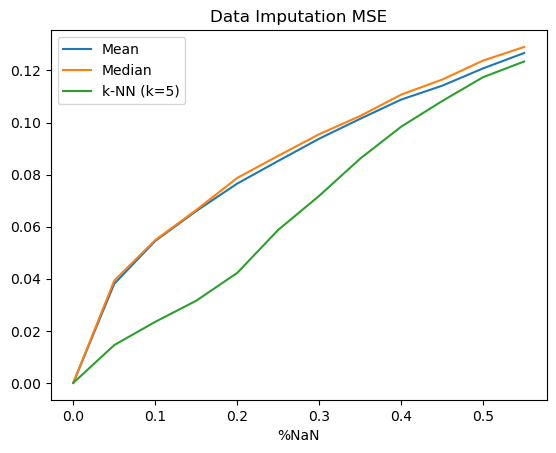

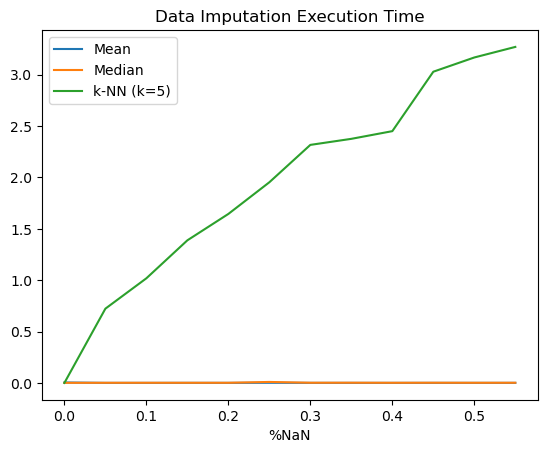

In [22]:
imputation_techniques = [
    (imputation_mean, "Mean"),
    (imputation_median, "Median"),
    (imputation_knn(5), "k-NN (k=5)"),
]
mse_statistic, time_statistic = visualize_evaluation(imputation_techniques)

,Mean,Median,k-NN (k=1),k-NN (k=4),k-NN (k=16),k-NN (k=65),k-NN (k=256),k-NN (k=512)
%NaN,,,,,,,,
0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.05,0.037182,0.039476,0.015966,0.014340,0.017032,0.020358,0.023573,0.024938
0.10,0.054704,0.054901,0.027302,0.023637,0.025922,0.028514,0.033787,0.036802
0.15,0.064945,0.067710,0.039752,0.031043,0.033573,0.037664,0.042668,0.045149
0.20,0.075709,0.078356,0.059163,0.043750,0.042032,0.046350,0.050932,0.054720
0.25,0.085771,0.087851,0.081819,0.058938,0.051673,0.054317,0.058633,0.062155
0.30,0.093869,0.095598,0.105915,0.074876,0.064334,0.064642,0.066956,0.070077
0.35,0.100840,0.102479,0.123316,0.088324,0.075954,0.075363,0.075990,0.077379
0.40,0.108682,0.110319,0.139735,0.101826,0.088559,0.084063,0.083034,0.086236


,Mean,Median,k-NN (k=1),k-NN (k=4),k-NN (k=16),k-NN (k=65),k-NN (k=256),k-NN (k=512)
%NaN,,,,,,,,
0.00,0.001576,0.001884,0.000966,0.001032,0.000963,0.000959,0.000941,0.000940
0.05,0.001564,0.002356,0.532912,0.509351,0.517340,0.514508,0.586182,0.569412
0.10,0.001630,0.002421,0.967351,0.932361,0.909513,0.925451,1.135310,1.063912
0.15,0.001675,0.002433,1.243328,1.222189,1.211299,1.319921,1.399125,1.451403
0.20,0.001612,0.002359,1.488762,1.471963,1.458937,1.591493,1.648242,1.865781
0.25,0.001609,0.002430,1.745009,1.796219,2.055555,1.812787,1.980091,2.060067
0.30,0.001655,0.002438,1.884528,1.961280,2.368445,2.107901,2.187579,2.339553
0.35,0.001689,0.002880,2.241981,2.309113,2.400961,2.360471,2.556742,2.741793
0.40,0.002020,0.002614,2.662060,2.553927,2.623984,2.495761,3.106627,3.002950


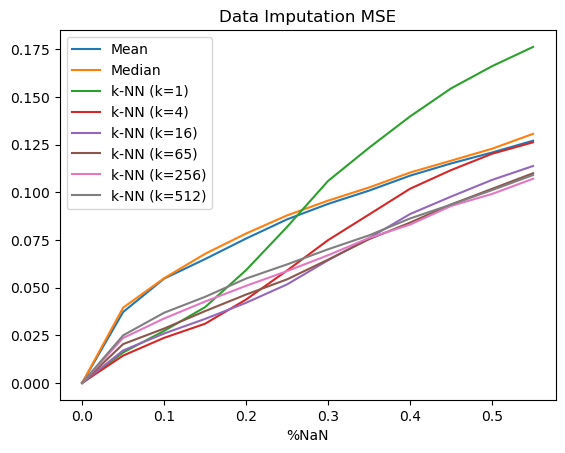

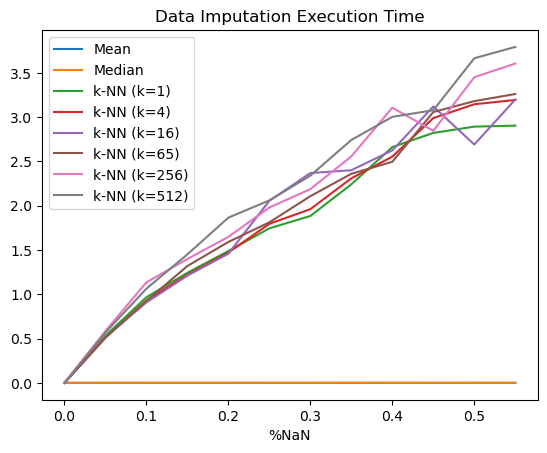

In [23]:
imputation_techniques = [
    (imputation_mean, "Mean"),
    (imputation_median, "Median"),
    (imputation_knn(1), "k-NN (k=1)"),
    #(imputation_knn(2), "k-NN (k=2)"),
    (imputation_knn(4), "k-NN (k=4)"),
    #(imputation_knn(8), "k-NN (k=8)"),
    (imputation_knn(16), "k-NN (k=16)"),
    #(imputation_knn(32), "k-NN (k=32)"),
    (imputation_knn(64), "k-NN (k=65)"),
    #(imputation_knn(128), "k-NN (k=128)"),
    (imputation_knn(256), "k-NN (k=256)"),
    (imputation_knn(512), "k-NN (k=512)")
]
mse_statistic, time_statistic = visualize_evaluation(imputation_techniques)

,Mean,Median,k-NN (k=256),k-NN (k=512),k-NN (k=1024),k-NN (k=2028),k-NN (k=4058),k-NN (k=8132)
%NaN,,,,,,,,
0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.05,0.038412,0.037882,0.023228,0.023292,0.022815,0.022879,0.022128,0.024841
0.10,0.054164,0.055267,0.034489,0.033838,0.033934,0.034138,0.033675,0.036467
0.15,0.065305,0.067141,0.042713,0.043474,0.043449,0.042331,0.043261,0.046802
0.20,0.076091,0.077818,0.050385,0.051080,0.049597,0.051737,0.051806,0.052882
0.25,0.085723,0.086172,0.059128,0.058927,0.058425,0.060206,0.058285,0.063476
0.30,0.093046,0.095041,0.067596,0.067367,0.066036,0.068951,0.067569,0.069936
0.35,0.100231,0.102585,0.074844,0.075539,0.075811,0.075135,0.075326,0.078297
0.40,0.107713,0.108835,0.084560,0.083366,0.084132,0.082538,0.082764,0.086688


,Mean,Median,k-NN (k=256),k-NN (k=512),k-NN (k=1024),k-NN (k=2028),k-NN (k=4058),k-NN (k=8132)
%NaN,,,,,,,,
0.00,0.001652,0.002087,0.000968,0.000983,0.000944,0.000946,0.000990,0.001150
0.05,0.001664,0.002383,0.580983,0.535261,0.537181,0.527234,0.527224,0.578770
0.10,0.001636,0.002417,1.014808,1.024106,0.958717,0.966214,0.960670,1.382559
0.15,0.001793,0.002383,1.393051,1.317878,1.297329,1.346133,1.377843,1.438069
0.20,0.001764,0.002394,1.630392,1.660969,1.591721,1.674058,1.693334,1.738972
0.25,0.001730,0.002409,2.004008,1.943040,1.930411,1.986514,2.004379,2.212901
0.30,0.001828,0.002449,2.321734,2.234504,2.206252,2.255293,2.396510,2.418691
0.35,0.002104,0.002496,2.582921,2.567078,2.515485,2.540248,2.709605,2.654938
0.40,0.001795,0.002480,3.083392,2.736321,2.648962,2.693190,2.758451,2.907147


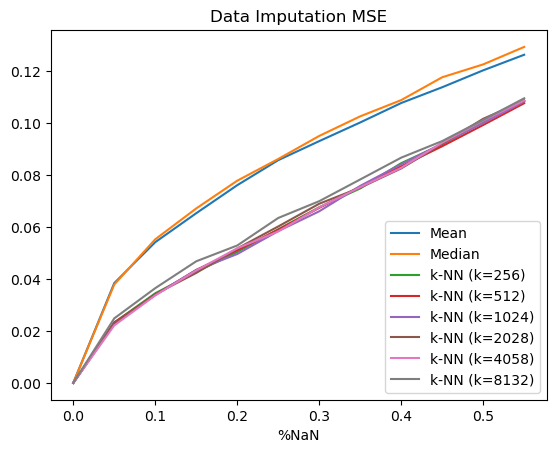

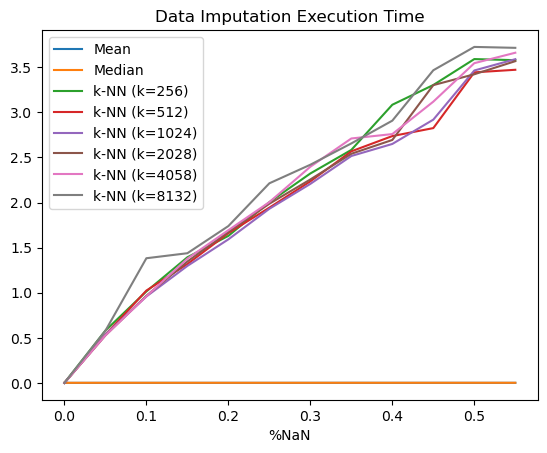

In [24]:
imputation_techniques = [
    (imputation_mean, "Mean"),
    (imputation_median, "Median"),
    (imputation_knn(256), "k-NN (k=256)"),
    (imputation_knn(256), "k-NN (k=512)"),
    (imputation_knn(256), "k-NN (k=1024)"),
    (imputation_knn(256), "k-NN (k=2028)"),
    (imputation_knn(256), "k-NN (k=4058)"),
    (imputation_knn(512), "k-NN (k=8132)")
]
mse_statistic, time_statistic = visualize_evaluation(imputation_techniques)

K-NN with k=4 and k=16 result in the lowest MSE for a dataset with less than 50% missing data! If time matters, simply using the mean is definitely the best choice!